In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#Text cleaning
import re, string
import emoji
import nltk
from tqdm import tqdm

# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))

In [ ]:
# Parameters
batch_size = 64
num_epochs = 5
num_samples = 10
learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size
decay = 1e-8

In [ ]:
# load the "irony" dataset(name=irony)
cache_dir = "./data_cache_"
subset_name = "irony"

train_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_)} instances loaded")

val_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_)} instances loaded")

test_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_)} instances loaded")

num_classes_ = np.unique(train_dataset_['label']).size

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to ./data_cache_/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.
Training dataset with 2862 instances loaded


Validation dataset with 955 instances loaded


Test dataset with 784 instances loaded


In [ ]:
#convert emojis into text
def strip_emoji(text):
    return emoji.demojize(text) 
    # return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji but not work

#Remove links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [ ]:
train_dataset_['text'][0:5]

['seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life',
 'look for the girl with the broken smile, ask her if she wants to stay while, and she will be loved. 💕🎵',
 'Now I remember why I buy books online @user #servicewithasmile',
 '@user @user So is he banded from wearing the clothes?  #Karma',
 'Just found out there are Etch A Sketch apps.  #oldschool #notoldschool']

In [ ]:
def preprocessing(dataset):
  sentences = dataset['text']
  pp_sentences = []
  # for sen in sentences:
  sen = strip_emoji(sentences)
  sen = decontract(sen)
  sen = strip_all_entities(sen)
  sen = clean_hashtags(sen)
  sen = filter_chars(sen)
  sen = remove_mult_spaces(sen)
  pp_sentences.append(sen)
  
  dataset['pp_text']=pp_sentences

  return dataset

train_dataset_ = train_dataset_.map(preprocessing)
val_dataset_ = val_dataset_.map(preprocessing)
test_dataset_ = test_dataset_.map(preprocessing)

  0%|          | 0/2862 [00:00<?, ?ex/s]

  0%|          | 0/955 [00:00<?, ?ex/s]

  0%|          | 0/784 [00:00<?, ?ex/s]

In [ ]:
train_dataset_['pp_text'][0:5]

[['seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life'],
 ['look for the girl with the broken smile, ask her if she wants to stay while, and she will be loved. :two hearts::musical note:'],
 ['now i remember why i buy books online'],
 ['so is he banded from wearing the clothes?'],
 ['just found out there are etch a sketch apps.']]

In [ ]:
# create Tokenizer object
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# create 'input_ids', 'token_type_ids', 'attention_mask' for train/val/test dataset
# def tokenize_function(dataset):
#     model_inputs = tokenizer(dataset['pp_text'], padding="max_length", max_length=100, truncation=True)
#     return model_inputs
def tokenize_function(dataset):
  input_ids = []
  attention_mask = []
  for sentence in dataset['pp_text']:
    model_inputs = tokenizer(sentence, padding="max_length", max_length=100, truncation=True)
    input_ids.append([i for set in model_inputs['input_ids'] for i in set])
    attention_mask.append([i for set in model_inputs['attention_mask'] for i in set])

  dataset['input_ids'] = input_ids
  dataset['attention_mask'] = attention_mask

  return dataset

train_dataset_ = train_dataset_.map(tokenize_function, batched=True)
val_dataset_ = val_dataset_.map(tokenize_function, batched=True)
test_dataset_ = test_dataset_.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# convert dataset to dataloader
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    # 'attention_mask' is also taken into consideration when constructing DataLoader(def forward())
    atten_tensor = torch.from_numpy(np.array(dataset['attention_mask']))
    
    tensor_dataset = TensorDataset(input_tensor, atten_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

# get all sentences ready for the model
train_loader = convert_to_data_loader(train_dataset_, num_classes_)
val_loader = convert_to_data_loader(val_dataset_, num_classes_)
test_loader = convert_to_data_loader(test_dataset_, num_classes_)

Build the model

In [ ]:
class RoBertaClassifier(nn.Module):
    def __init__(self, freeze_bert, aleatoric_use, num_labels):
        super(RoBertaClassifier, self).__init__()

        # use the pretrained bert model corresponding to the previous tokenizer
        self.aleatoric_use = aleatoric_use
        self.bert = AutoModel.from_pretrained("roberta-base")
        self.config = self.bert.config

        # specify the parameter for the classifier
        n_input = self.config.hidden_size
        n_hidden = 50
        p_ = 0.2

        # add dense layers to act as the classifier
        self.classifier = nn.Linear(n_input, n_hidden)

        self.predict = torch.nn.Linear(n_hidden, num_labels)   # predicted output
        self.get_var = torch.nn.Linear(n_hidden, num_labels)   # predicted variance

        # execute when freeze_bert=True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            for param in self.bert.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        # get the outputs of the roberta model
        bert_outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)

        # extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_outputs = bert_outputs[0][:,0,:]

        # Feed input to classifier to compute results(one number for each class)
        x = last_hidden_state_outputs  # 64*768
        x = self.classifier(x)  # 64*50
        x = F.relu(x)  # 64*50
        x = F.dropout(x, p=0.2)  # 64*50
        
        logits = self.predict(x)  # logits layer 64*2
        if self.aleatoric_use:  # consider aleatoric uncertainty --> two sets of output
          sigma = self.get_var(x)  # uncertainty layer 64*2
          return logits, sigma
        else:
          return logits

In [ ]:
def initialize_model(epochs):
    # Instantiate Bert Classifier
    model_ = RoBertaClassifier(freeze_bert=True, aleatoric_use=True, num_labels=num_classes_)
    # model_comb.to(device)

    # Set up optimizer
    optimizer = optim.AdamW(model_.parameters(),
                 lr=learning_rate,    # learning rate, set to default value
                 eps=decay    # decay, set to default value
                 )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_loader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return model_, optimizer, scheduler

In [ ]:
model_comb, optimizer, scheduler = initialize_model(epochs=num_epochs)
model_comb

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RoBertaClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [ ]:
def combined_loss_function(labels, x_i):
  golden_labels = labels.view(-1,1)
  y_hat = torch.zeros(labels.size(0), num_classes_)  # 64*2
  y_hat = y_hat.scatter(1, golden_labels, 1) 

  y_i = torch.zeros((num_samples, labels.size(0), num_classes_)) # 10*64*2

  for t in range(num_samples):
    y_i[t] = y_hat

  # start computing loss
  loss0 = torch.log(torch.sum(torch.exp(x_i),dim=2))
            
  x_itc_hat = torch.sum(x_i*y_i,dim=2)
  loss1 = torch.mean(torch.exp(x_itc_hat-loss0),dim=0)

  loss = torch.sum(-torch.log(loss1))
  return loss

In [ ]:
def apply_dropout(m):
  if type(m) == F.dropout:  # type(m) == nn.Dropout or
    m.train()

# net.eval()
# net.apply(apply_dropout)

In [ ]:
def train_combined(num_epochs, model, train_dataloader, dev_dataloader):  

    loss_fn = combined_loss_function  # create loss function object
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    # Store the data for plotting
    X = []
    train_losses_set = []
    train_accuracy_set = []
    dev_losses_set = []
    dev_accuracy_set = []
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        # batch_atten(atten_mask) is also used to compute the model output
        for i, (batch_input_ids, batch_atten, batch_labels) in enumerate(train_dataloader):

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            mu, sigma = model(batch_input_ids, batch_atten) # 64*2

            prob_total = torch.zeros((num_samples, batch_labels.size(0), num_classes_)) # 10*64*2
            x_i = torch.zeros((num_samples, batch_labels.size(0), num_classes_)) # 10*64*2
            for t in range(num_samples):
              epsilon = torch.randn(sigma.size())  # 64*2
              logit = mu + torch.mul(sigma, epsilon)  # 64*2
              x_i[t] = logit
              prob_total[t] = F.softmax(logit, dim=1) # 64*2 into probability
            prob_ave = torch.mean(prob_total, 0) # compute the mean of the 10 64*2 matrices

            # Compute the loss for the current batch of data 
            batch_loss = loss_fn(batch_labels, x_i)
            print("my batch_loss:{}".format(batch_loss))

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Update the learning rate
            scheduler.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            pred_y = torch.max(prob_ave, 1)[1].data.numpy()
            total_correct += (pred_y == batch_labels.data.numpy()).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        X.append(e+1)
        train_losses_set.append(np.mean(train_losses))
        train_accuracy_set.append(train_accuracy)

        model.eval()  # Switch model to evaluation mode
        model.apply(apply_dropout) # Keep the dropout layer open when testing
        
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_atten, dev_labels in dev_dataloader:

            # Use the model to performance forward inference on the development data
            dev_mu, dev_sigma = model(dev_input_ids, dev_atten)
            
            dev_prob_total = torch.zeros((num_samples, dev_labels.size(0), num_classes_))
            dev_x_i = torch.zeros((num_samples, dev_labels.size(0), num_classes_))
            for t in range(num_samples):
              epsilon = torch.randn(dev_sigma.size())
              logit = dev_mu + torch.mul(dev_sigma, epsilon)
              dev_x_i[t] = logit
              dev_prob_total[t] = F.softmax(logit, dim=1)
            dev_prob_ave = torch.mean(dev_prob_total, 0)

            # Compute the loss for the development data
            dev_loss = loss_fn(dev_labels, dev_x_i) # dev_loss computed by my loss_function

            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())

            # Count the number of correct predictions
            dev_output_y = torch.max(dev_prob_ave, 1)[1].data.numpy()
            # predicted_labels = dev_output_y.argmax(1)
            total_correct += (dev_output_y == dev_labels.data.numpy()).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
        
        dev_losses_set.append(np.mean(dev_losses))
        dev_accuracy_set.append(dev_accuracy)
    
    # Plotting to show the accuracy and loss
    plt.figure()
    plt.plot(X,train_accuracy_set,'ob--',label='Train Accuracy')
    plt.plot(X,dev_accuracy_set,'or--',label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy(%)')
    
    plt.figure()
    plt.plot(X,train_losses_set,'ob--',label='Train Loss')
    plt.plot(X,dev_losses_set,'or--',label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')

    # plt.figure()
    # plt.plot(X,train_uncertainty_set,'ob--',label='Train Loss')
    # plt.plot(X,dev_uncertainty_set,'or--',label='Validation Loss')
    # plt.legend()
    # plt.xlabel('Number of epochs')
    # plt.ylabel('Combined Uncertainty')
    
    return model

Train and validate

my batch_loss:44.2220458984375
my batch_loss:44.44906234741211
my batch_loss:43.960262298583984
my batch_loss:44.3194580078125
my batch_loss:44.23692321777344
my batch_loss:44.4203987121582
my batch_loss:44.885311126708984
my batch_loss:44.13622283935547
my batch_loss:45.105926513671875
my batch_loss:44.02789306640625
my batch_loss:43.886390686035156
my batch_loss:45.08979034423828
my batch_loss:44.190494537353516
my batch_loss:45.362220764160156
my batch_loss:46.363372802734375
my batch_loss:45.11747360229492
my batch_loss:44.8652229309082
my batch_loss:44.084415435791016
my batch_loss:44.982337951660156
my batch_loss:43.81110382080078
my batch_loss:43.952877044677734
my batch_loss:44.86285400390625
my batch_loss:44.16911697387695
my batch_loss:44.65040588378906
my batch_loss:43.47669219970703
my batch_loss:44.53895568847656
my batch_loss:44.20357131958008
my batch_loss:44.059871673583984
my batch_loss:44.40980529785156
my batch_loss:43.65247344970703
my batch_loss:43.89459228515625
m

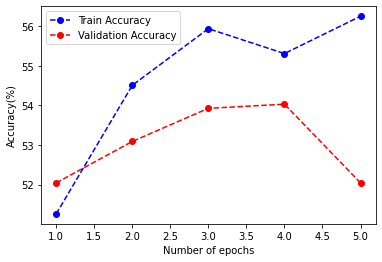

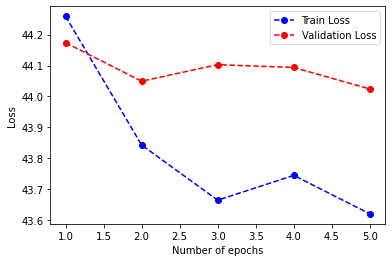

In [ ]:
# model combined uncertainty
trained_model = train_combined(num_epochs=num_epochs, model=model_comb, train_dataloader=train_loader, dev_dataloader=val_loader)

predict on the test dataset

In [ ]:
# keep dropout closed
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, atten, labels in test_loader:
        test_mu, test_sigma = trained_model(inputs, atten)
        # take the label with biggest output as the predicted label
        predicted_labels = test_mu.argmax(1)

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

In [ ]:
gold_labs, pred_labs = predict_nn(trained_model, test_loader)

In [ ]:
from sklearn.metrics import f1_score
f1_score(gold_labs, pred_labs, average='macro')

0.5482312495523594

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_labs, pred_labs)

0.548469387755102

test with dropout layer open, sample 5 times and get average

In [ ]:
# keep dropout open
def predict_nn_drop(trained_model, test_loader):

    trained_model.eval()
    trained_model.apply(apply_dropout)

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, atten, labels in test_loader:
        test_prob_total = torch.zeros((num_samples, labels.size(0), num_classes_))
        test_mu, test_sigma = trained_model(inputs, atten)
        # take the label with biggest output as the predicted label
        for t in range(num_samples):
          epsilon = torch.randn(test_sigma.size())
          logit = test_mu + torch.mul(test_sigma, epsilon)
          test_prob_total[t] = F.softmax(logit, dim=1)
        test_prob_ave = torch.mean(test_prob_total, 0)
        predicted_labels = torch.max(test_prob_ave, 1)[1].data.numpy()

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

In [ ]:
gold_labs, pred_labs = predict_nn_drop(trained_model, test_loader)

# classification report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = ['irony', 'not irony']
print("The classification report is:")
print(classification_report(gold_labs, pred_labs,target_names=target_names))

# confusion matrix
cm = confusion_matrix(gold_labs, pred_labs)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
print("The confusion matrix is:")
print(df_cm)

The classification report is:
              precision    recall  f1-score   support

       irony       0.67      0.40      0.50       473
   not irony       0.44      0.70      0.54       311

    accuracy                           0.52       784
   macro avg       0.55      0.55      0.52       784
weighted avg       0.58      0.52      0.52       784

The confusion matrix is:
           irony  not irony
irony        190        283
not irony     93        218


In [ ]:
from sklearn.metrics import f1_score
f1_score(gold_labs, pred_labs, average='macro')

0.5197956577266922

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_labs, pred_labs)

0.5204081632653061